# Extended Kalman Filter (EKF)

## Requisitos

In [61]:
import pandas as pd
import numpy as np

import scipy
import scipy.linalg
from scipy import stats
from scipy.stats import norm

import sympy
from sympy import init_printing
from sympy.utilities.codegen import codegen
from sympy import Symbol, symbols, Matrix, sin, cos

import webbrowser #hiperlink
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
init_printing(use_latex=True)

## Projeto das estimativas iniciais

### Vetor de estados de entrada

$$ \mathbf{x}_{k-1} = \begin{bmatrix} x \\ y \\ \theta \end{bmatrix} = \begin{bmatrix} \text{Posição X} \\ \text{Posição Y} \\ \text{Heading} \end{bmatrix} $$

### Vetor de controle de entrada

Sua inserção nas equações depende da origem do problema.

Comentário(s): (investigar se é necessário no caso de veículos autônomos)

$$ \mathbf{u}_{k} = \begin{bmatrix} v \\ \psi \end{bmatrix} = \begin{bmatrix} \text{Velocidade} \\ \text{Yaw Rate} \end{bmatrix} $$

## Sistema não-linear dinâmico a ser rastreado

$$ \mathbf{x}_{k} = \mathbf{f}(\mathbf{x}_{k-1}, \mathbf{u}_k) + w_k + \tau_k $$

### Ruído nos vetores de estado e controle

Os ruídos são variáveis aleatórias com normal de média nula, visto que a influência dos ruídos é filtrada pelas covariâncias.

Comentário(s): é a solução estocástica ótima.

$$ w_k = \mathcal{N}(0, Q) $$

$$ \tau_k = \mathcal{N}(0, M) $$

## Sistema linearizado por série de Taylor

O sistema não-linear estocástico pode ser linearizado e descrito por meio de equações cinemáticas:

Comentário(s): (hodometria típica em robótica móvel) (escolhi a mais simples para facilitar o ajuste fino)

$$ \mathbf{x}_k = \begin{bmatrix} x_k \\ y_k \\ \theta_k \end{bmatrix} \implies \mathbf{x}_{k} = \begin{bmatrix} x_{k-1} \\ y_{k-1} \\ \theta_{k-1} \end{bmatrix} +  \begin{bmatrix} v_{k}\cdot\cos(\theta_{k-1})\cdot dt \\ v_{k}\cdot\sin(\theta_{k-1})\cdot dt \\ \psi_{k}\cdot dt \end{bmatrix}$$

Para facilitar as operações foi adotado a seguinte notação:

$$ \mathbf{f}(x_{k-1}, u_k) = \begin{bmatrix} f_1 \\ f_2 \\ f_3 \end{bmatrix} = \begin{bmatrix} x_{k-1} + v_{k}\cdot\cos(\theta_{k-1})\cdot dt \\ y_{k-1} + v_{k}\cdot\sin(\theta_{k-1})\cdot dt \\ \theta_{k-1} + \psi_{k}\cdot dt \end{bmatrix}$$

$\mathbf{F}_k$ é a matriz Jacobiana de $f(x_{k-1}, u_k)$ com relação ao vetor de estados.

$$
\mathbf{F}_k = \frac{\partial f(x_{k-1}, u_k)}{\partial x_{k-1}} \implies \mathbf{F}_k = \begin{bmatrix}
\frac{\partial f_1}{\partial x} & 
\frac{\partial f_1}{\partial y} &
\frac{\partial f_1}{\partial \theta}\\
\frac{\partial f_2}{\partial x} & 
\frac{\partial f_2}{\partial y} &
\frac{\partial f_2}{\partial \theta} \\
\frac{\partial f_3}{\partial x} & 
\frac{\partial f_3}{\partial y} &
\frac{\partial f_3}{\partial \theta}
\end{bmatrix}
$$

$$\mathbf{F}_k =\begin{bmatrix}
1 & 
0 &
-v_{k}\cdot\sin(\theta_{k-1})\cdot dt \\
0 & 
1 &
v_{k}\cdot\cos(\theta_{k-1})\cdot dt \\
0 & 
0 &
1
\end{bmatrix}
$$

$\mathbf{G}_k$ é a matriz Jacobiana de $f(x_{k-1}, u_k)$ com relação ao vetor de controle.

$$\mathbf{G}_k = \frac{\partial f(x_{k-1}, u_{k})}{\partial u_{k}} \implies \mathbf{G}_k = \begin{bmatrix}
\frac{\partial f_1}{\partial v} & \frac{\partial f_1}{\partial \psi} \\
\frac{\partial f_2}{\partial v} & \frac{\partial f_2}{\partial \psi} \\
\frac{\partial f_3}{\partial v} & \frac{\partial f_3}{\partial \psi}
\end{bmatrix}$$

$$\mathbf{G}_k = \begin{bmatrix}
\cos(\theta_{k-1})\cdot dt & 0 \\
\sin(\theta_{k-1})\cdot dt & 0 \\
0 & dt
\end{bmatrix}$$

## Matriz de covariância de ruídos do sistema de posições

$$\mathbf{Q} = \begin{bmatrix}
\sigma_{x}^{2} & 0 & 0\\
0 & \sigma_{y}^{2} & 0\\
0 & 0 & \sigma_{\theta}^{2}
\end{bmatrix}$$

## Matriz de covariância de ruídos dos sinais de controle de movimento

Controle de erro nas variáveis $v$ e $\psi$ convertido em controle de erro nas variáveis $x$, $y$ e $\theta$.

Comentário(s): (pode ser otimizado por ajuste fino) (filtro que atualiza a cada predição também otimiza)

$$\mathbf M = \begin{bmatrix}
\sigma_{v}^{2} & 0 \\
0 & 
\sigma_{\psi}^{2}
\end{bmatrix}
$$

## Matriz de covariância de estado 

Comentário(s): (investigar melhor) (está associado a origem do veículo)

Certeza da origem:

$$\mathbf{P} = \begin{bmatrix}
0 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0
\end{bmatrix}$$

Valor arbitrado razoável (o filtro consegue corrigir em execução)

$$\mathbf{P} = \mathbf{Q} $$

Valor arbitrado pelo professor:

$$\mathbf{P} = \begin{bmatrix}
10 & 0 & 0\\
0 & 10 & 0\\
0 & 0 & 10
\end{bmatrix}$$

## Sistema sensorial não-linear para observar $x_k$

Verificar a propagação de erros do sensor quanto a linearidade. Se for linear, então a distribuição de probabilidades será Gaussiana. Caso contrário, a distribuição de probabilidades será diferente (Poisson por exemplo).

Comentário(s): (otimização sensível !!!) (teorema central do limite) (GPS -> linear)

$$ \mathbf{z}_k = \mathbf{h}(\mathbf{x}_k, v_k) $$

### Ruído no sistema sensorial

Os ruídos são variáveis aleatórias com normal de média nula, visto que a influência dos ruídos é filtrada pelas covariâncias.

Comentário(s): é a solução estocástica ótima.

$$ v_k = \mathcal{N}(0, R) $$

## Sistema sensorial linearizado

Válido somente se a propagação de erros do sensor for linear !

Comentário(s): (GNSS/GPS ->  linear) (Senão -> outra distribuição)

$$\mathbf{z}_{k} = \begin{bmatrix}
x_{gps,k} \\
y_{gps,k}
\end{bmatrix}$$ 

Para facilitar as operações foi adotado a seguinte notação:

$$ \mathbf{h}(x_{k}) = \begin{bmatrix} h_1 \\ h_2 \end{bmatrix} = \begin{bmatrix}
x_{gps, k} \\
y_{gps, k}
\end{bmatrix}$$

$\mathbf{H}_k$ é a matriz Jacobiana de $h(x_{k})$ com relação ao vetor de estados.

$$\mathbf{H}_k = \frac{\partial h(x_{k})}{\partial x_{k-1}} \implies \mathbf{H}_k = \begin{bmatrix}
\frac{\partial h_1}{\partial x} & 
\frac{\partial h_1}{\partial y} &
\frac{\partial h_1}{\partial \theta}\\
\frac{\partial h_2}{\partial x} & 
\frac{\partial h_2}{\partial y} &
\frac{\partial h_2}{\partial \theta} \\
\end{bmatrix}$$

$$ \mathbf{H}_{k} = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0
\end{bmatrix}$$

## Esperança do sistema sensorial linearizado

$$\mathbf{h}_{k|k-1} = \begin{bmatrix}
x_{gps, k|k-1} \\
y_{gps, k|k-1}
\end{bmatrix}$$

## Matriz de covariância do sensor

$$ \mathbf{R} = \begin{bmatrix}
\sigma_{zx}^{2} & 0 \\
0 & 
\sigma_{zy}^{2}
\end{bmatrix}$$

## Matriz identidade

$$\mathbf{I} = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix}$$

# Equações de previsão das esperanças

### Leitura do sistema sensorial

$$ \mathbf{z}_{k} = \begin{bmatrix}
x_{gps,k} \\
y_{gps,k}
\end{bmatrix} $$ 

### Estimativa do vetor de estados

$$ \mathbf{x}_k = \mathbf{x}_{k-1} + \begin{bmatrix} v_{k-1}\cdot\cos(\theta_{k-1})\cdot dt \\ v_{k-1}\cdot\sin(\theta_{k-1})\cdot dt \\ \psi_{k-1}\cdot dt \end{bmatrix} $$

### Estimativa da covariância de erro

$$ \mathbf{P}_{k|k-1} = \mathbf{F}_{k}\mathbf{P}_{k-1|k-1}\mathbf{F}_{k}^{T} + \mathbf{G}_{k}\mathbf{M}_{k-1}\mathbf{G}_{k}^{T} + \mathbf{Q}_{k} $$

### Esperança do sistema sensorial

$$\mathbf{h}_{k|k-1} = \begin{bmatrix}
x_{gps, k|k-1} \\
y_{gps, k|k-1}
\end{bmatrix}$$

# Equações de correção das esperanças

### Ganho de Kalman

Método dos mínimos quadrados.

$$ \mathbf{K}_{k} = \mathbf{P}_{k|k-1}\mathbf{H}_{k}^{T}(\mathbf{H}_{k}\mathbf{P}_{k|k-1}\mathbf{H}_{k}^{T} + \mathbf{R}_{k})^{-1} $$

### Correção do vetor de estados

$$ \mathbf{x}_{k|k} = \mathbf{x}_{k|k-1} + \mathbf{K}_{k}(\mathbf{z}_{k}-\mathbf{h}_{k|k-1}) $$

### Correção da covariância do erro

$$ \mathbf{P}_{k|k} = (\mathbf{I} - \mathbf{K}_{k}\mathbf{H}_{k})\mathbf{P}_{k|k-1} $$

# Conjunto de dados

Fonte: https://www.tu-chemnitz.de/projekt/smartLoc/gnss_dataset.html.en#Datasets

### Berlin Potsdamer Platz (~49% NLOS)

In [62]:
data1 = "DATASET1.csv"
data1 = pd.read_csv(data1, sep=',')
data1

,GPSWeek [weeks],GPSSecondsOfWeek [s],Longitude (lon) [deg],Latitude (lat) [deg],Height above ellipsoid (height) [m],Longitude (GT Lon) [deg],Latitude (GT Lat) [deg],Height above ellipsoid (GT Height) [m],"Heading (0° = East, counterclockwise) - (GT Heading) [rad]",Acceleration (GT Acceleration) [ms^2],GPSSecondsOfWeek [s] - Velocity,Velocity [meter/second],GPSSecondsOfWeek [s] - Yawrate,Yaw-Rate [rad/s]
0,1900.0,126642.0,13.373692,52.504600,80.236,13.373671,52.504585,76.020936,1.243817,0.645004,126642.00,6.077778,126642.00,-0.016930
1,1900.0,126642.2,13.373697,52.504610,80.233,13.373676,52.504595,76.027829,1.240403,0.566129,126642.02,6.083333,126642.02,-0.016232
2,1900.0,126642.2,13.373697,52.504610,80.233,13.373676,52.504595,76.027829,1.240403,0.566129,126642.04,6.111111,126642.04,-0.016057
3,1900.0,126642.2,13.373697,52.504610,80.233,13.373676,52.504595,76.027829,1.240403,0.566129,126642.06,6.127778,126642.06,-0.014486
4,1900.0,126642.2,13.373697,52.504610,80.233,13.373676,52.504595,76.027829,1.240403,0.566129,126642.08,6.127778,126642.08,-0.015708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14126,1900.0,126924.7,13.373559,52.504508,80.125,13.373564,52.504490,77.886868,-2.090978,-1.057214,126924.53,5.105556,126924.53,-0.060039
14127,1900.0,126924.7,13.373559,52.504508,80.125,13.373564,52.504490,77.886868,-2.090978,-1.057214,126924.55,5.069444,126924.55,-0.063705
14128,1900.0,126924.7,13.373559,52.504508,80.125,13.373564,52.504490,77.886868,-2.090978,-1.057214,126924.57,5.041667,126924.57,-0.066323
14129,1900.0,126924.7,13.373559,52.504508,80.125,13.373564,52.504490,77.886868,-2.090978,-1.057214,126924.59,5.022222,126924.59,-0.069813


In [63]:
latitude = data1['Latitude (lat) [deg]']
longitude = data1['Longitude (lon) [deg]']
altitude = data1['Height above ellipsoid (height) [m]']
latitudeGT = data1['Latitude (GT Lat) [deg]']
longitudeGT = data1['Longitude (GT Lon) [deg]']
altitudeGT = data1['Height above ellipsoid (GT Height) [m]']
headingGT = data1['Heading (0° = East, counterclockwise) - (GT Heading) [rad]']
course = data1['Heading (0° = East, counterclockwise) - (GT Heading) [rad]']
speed = data1['Velocity [meter/second]']
yawrate = data1['Yaw-Rate [rad/s]']

# Pegar os timestamps das medições para utilizar na fusão do EKF
gps_time = data1['GPSSecondsOfWeek [s]']
imu_time = data1['GPSSecondsOfWeek [s] - Velocity']

# Taxas de amostragem
dt = 1.0/50.0 # 50 Hz (CAN) (VELOCITY.csv e YAWRATE.csv)
dtGPS = 1.0/5.0 # 5 Hz (sensor GPS de baixo custo) (NAV-POSLLH.csv)

In [64]:
# Approx. Lat/Lon to Meters to check Location
# Calculating position using data from GPS and GT (Ground Truth)
RadiusEarth = 6378388.0 # m
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°
arcGT= 2.0*np.pi*(RadiusEarth+altitudeGT)/360.0 # m/°

# Equirectangular projection (https://en.wikipedia.org/wiki/Equirectangular_projection)
# x = r * cos(latitude)*(longitude_{K} - longitude_{K-1})
# y = r * (latitude_{K} - latitude_{K-1})
dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m

dxGT = arcGT * np.cos(latitudeGT*np.pi/180.0) * np.hstack((0.0, np.diff(longitudeGT))) # in m
dyGT = arcGT * np.hstack((0.0, np.diff(latitudeGT))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)
mxGT = np.cumsum(dxGT)
myGT = np.cumsum(dyGT)

GPS=(imu_time >= gps_time).astype('bool')

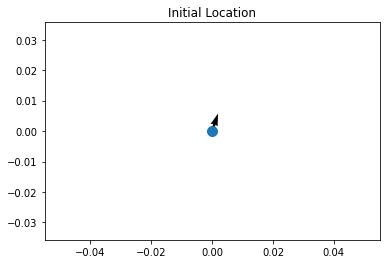

In [65]:
# course in radians, yawrate in radians/s, and speed in m/s
x_s = np.matrix([[mx[0], my[0], course[0]]]).T
u_c = np.matrix([[speed[0], yawrate[0]]]).T
#print(x, x.shape)
#print(u, u.shape)

U=float(np.cos(x_s[2])*u_c[0])
V=float(np.sin(x_s[2])*u_c[0])

# quiver plots a 2D field of arrows. X, Y define the arrow locations, U, V define the arrow directions.

plt.quiver(x_s[0], x_s[1], U, V)
plt.scatter(float(x_s[0]), float(x_s[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

In [66]:
#measurements = np.vstack((mx, my, heading))
measurements = np.vstack((mx, my))
# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)
#print(m)

(2, 14131)


In [67]:
# Preallocation for Plotting
x0     = []
x1     = []
x2     = []
x3     = []
x4     = []
Zx     = []
Zy     = []
Px     = []
Py     = []
Ppsi   = []
Pv     = []
Pdpsi  = []
Kx     = []
Ky     = []
Kpsi   = []
Kv     = []
Kdpsi  = [] 
dstate = []

# Para a plotagem da distância euclidiana
x0p    = [0]
x1p    = [0]
mxp    = [0]
myp    = [0]
mxGTp  = [0]
myGTp  = [0]
innov_x= []
innov_y= []

### Berlin Gendarmenmarkt (~37% NLOS)

In [68]:
#vou fazer depois
#data2 = "DATASET2.csv"
#data2 = pd.read_csv(data2, sep=',')
#data2

### Simulação

In [69]:
#vou fazer depois

# Implementação do EKF em Python

In [70]:
class EKF():
    def __init__(self, dt, dtGPS):
        # Taxa de amostragem das medições
        self.dt = dt
        self.dtGPS = dtGPS

        self.x = None
        self.F = None
        self.u = None
        self.G = None
        
        self.Q = None
        self.M = None
        self.P = np.diag([10.0, 10.0, 10.0])
        
        self.h = None
        self.z = None
        self.y = None
        self.H = None
        self.R = None
        self.K = None
        self.I = np.eye(3)
        # Desvios padrões das variáveis de estado
        self.noise_pxy = 0.5*2.0*self.dt**2
        self.noise_tht = 0.01*self.dt
        # Desvios padrões dos sinais de controle
        self.noise_vel = 2.0*self.dt
        self.noise_psi = 0.1*self.dt
        # Desvios padrões das medições
        self.noise_gps = 4
    
    def init_dynamic_system(self, psx, psy, tht, vel, psi):
        self.x = np.matrix([[psx, psy, tht]]).T # init_state
        self.u = np.matrix([[vel, psi]]).T # init_control
        
    def set_matrices(self, tht, vel):
        f13 = float(-vel*np.sin(tht)*self.dt)
        f23 = float( vel*np.cos(tht)*self.dt)
        self.F = np.matrix([[1.0, 0.0, f13],
                            [0.0, 1.0, f23],
                            [0.0, 0.0, 1.0]])
        g11 = float(np.cos(tht))
        g21 = float(np.sin(tht))
        g32 = float(self.dt)
        self.G = np.matrix([[g11, 0.0],
                            [g21, 0.0],
                            [0.0, g32]])
        self.Q = np.diag([self.noise_pxy**2, self.noise_pxy**2, self.noise_tht**2])
        self.M = np.diag([self.noise_vel**2, self.noise_psi**2])
        self.H = np.matrix([[1.0, 0.0, 0.0],
                              [0.0, 1.0, 0.0]])
        self.R = np.diag([self.noise_gps**2, self.noise_gps**2])
    
    def dynamic_system(self):
        x1 = self.x[0,0]+self.u[0,0]*np.cos(self.u[1,0])*self.dt
        x2 = self.x[1,0]+self.u[0,0]*np.sin(self.u[1,0])*self.dt
        x3 = self.x[2,0]+self.u[1,0]*self.dt
        self.x = np.matrix([[x1, x2, x3]]).T # state ahead
        self.u = self.u # control sign ahead
        
    def predict(self):
        f1 = self.u[0,0]*np.cos(self.x[2,0])*self.dt
        f2 = self.u[0,0]*np.sin(self.x[2,0])*self.dt
        f3 = self.u[1,0]*self.dt
        self.x = self.x + np.matrix([[f1, f2, f3]]).T
        self.P = ((self.F)*(self.P)*(self.F.T))+((self.G)*(self.M)*(self.G.T))+self.Q
        return self.x, self.P
    
    def residual(self, k):
        self.h = np.matrix([[float(self.x[0,0])],
                       [float(self.x[1,0])]])
        self.z = measurements[:,k].reshape((self.H).shape[0],1)
        self.y = self.z-self.h
        return self.z, self.y
    
    def update(self):
        S = (self.H)*(self.P)*(self.H).T + self.R
        self.k = ((self.P)*(self.H).T)*np.linalg.inv(S)
        self.x = self.x + (self.k)*(self.y)
        self.P = (self.I - ((self.k)*(self.H)))*self.P
        return self.k, self.x, self.P


In [71]:
ekf = EKF(dt, dtGPS)
ekf.init_dynamic_system(mx[0],my[0],course[0],speed[0],yawrate[0])
ekf.set_matrices(course[0],speed[0])
for k in range(m):
    f,P = ekf.predict()
    z,y = ekf.residual(k)
    k,f,P = ekf.update()
    
    # ===============================
    # Save states for Plotting
    # ===============================
    x0.append(float(f[0]))
    x1.append(float(f[1]))
    x2.append(float(f[2]))
    Zx.append(float(z[0]))
    Zy.append(float(z[1]))
    
    # Innovation
    innov_x.append(y[0,0])
    innov_y.append(y[1,0])
    
    # Covariance
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Ppsi.append(float(P[2,2]))
    
    # Kalman gain
    Kx.append(float(k[0,0]))
    Ky.append(float(k[1,0]))
    Kpsi.append(float(k[2,0]))

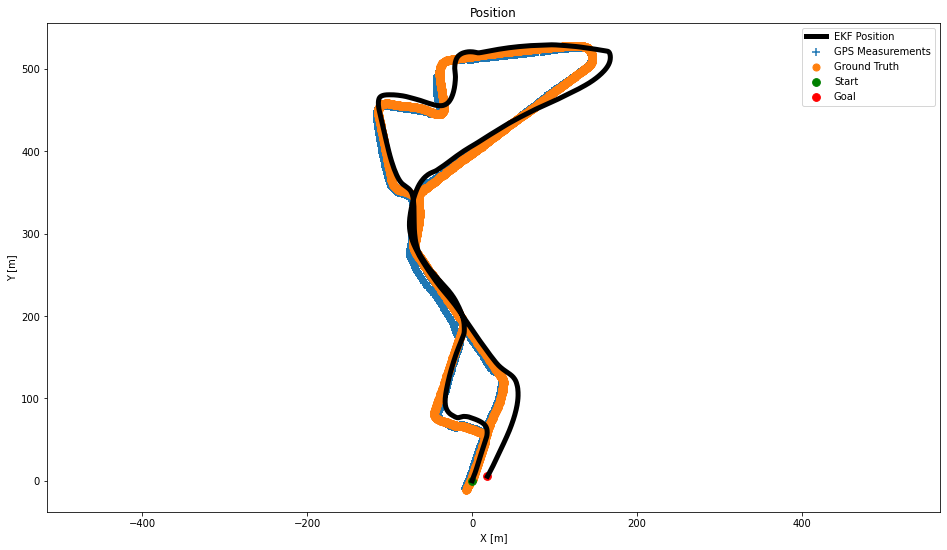

In [72]:
fig = plt.figure(figsize=(16,9))

# EKF State
plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
plt.plot(x0,x1, label='EKF Position', c='k', lw=5)

# Measurements
plt.scatter(mx,my, s=50, label='GPS Measurements', marker='+')

# Ground Truth
plt.scatter(mxGT,myGT, s=50, label='Ground Truth', marker='o')

# Start/Goal
plt.scatter(x0[0],x1[0], s=60, label='Start', c='g')
plt.scatter(x0[-1],x1[-1], s=60, label='Goal', c='r')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Position')
plt.legend(loc='best')
plt.axis('equal')

Está bem errado este primeiro gráfico! Vou verificar as equações e implementar alguns detalhes das implementações anteriores para verificar se mudar algo, mas provavelmente o modelo adotado está simplificado demais!

A minha ideia é semelhante a figura abaixo, em que a saída desejada controlador u(t) é o erro e(t) vezes o controlador, assim poderíamos utilizar um controlador PID, por exemplo, e ajustar o vetor de estados com os ganhos proporcional; integral e diferencial, mas vai aumentar bastante a complexidade da implementação (pode ser uma implementação futura)

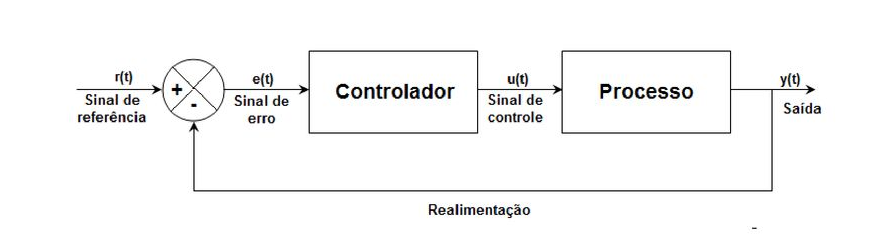

Outra opção de dataset: https://www.nuscenes.org/nuplan#download

Outra opção de dataset: https://www.mrpt.org/malaga_dataset_2009
Esse em especial eu observei do artigo https://www.mdpi.com/1424-8220/17/9/2140, que o senhor recomendou do UKF e o mesmo apresenta Ground Truth com acurácia de cm.